In [2]:
import wandb
import numpy as np
import matplotlib.pyplot as plt

api = wandb.Api()
#run = api.run("<entity>/<project>/<run_id>")
id_baseline_64 = 'lyff59ic'
id_tanh_64 = '8aiug7vh'
id_baseline_32 = 'vp056zrl'
id_tanh_32 = 'aus0fnzu'
#run = api.run("renbotu/fno/fcuvm220")
#run = api.run("crwhite/lowprecision/k17c3wsv")


In [31]:
import numpy as np
# Define the project name and IDs
'''
project_name = "renbotu/fno"
ids = {
    'Baseline+modes64': 'lyff59ic',
    'AMP+HP+tanh+modes64': '8aiug7vh',
    'Baseline+modes32': 'vp056zrl',
    'AMP+HP+tanh+modes32': 'aus0fnzu'
}
'''
project_name = "crwhite/lowprecision"
ids = {
    'Baseline+modes64': 'gnjbaroy',
    'AMP+HP+tanh+modes64': '5nnvhtkm',
    'Baseline+modes32': 'pgyti02y',
    'AMP+HP+tanh+modes32': 'fuxe4vng'
}

ids_seed2 = {
    'Baseline+modes64': '5squto9e',
    'AMP+HP+tanh+modes64': 'nua0wf1u',
    'Baseline+modes32': 'd1ddymyb',
    'AMP+HP+tanh+modes32': 'k17c3wsv'
}


# Define the metrics to extract
metrics = ["time", "128_h1"]

# Create dictionaries to store the data
data_time = {}
data_128_h1 = {}
data_128_h1_seed2 = {}

# Loop through the methods and extract the metrics
for method, exp_id in ids.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    data_time[method] = np.array(time_data)
    data_128_h1[method] = np.array(h1_data)

for method, exp_id in ids_seed2.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    data_128_h1_seed2[method] = np.array(h1_data)


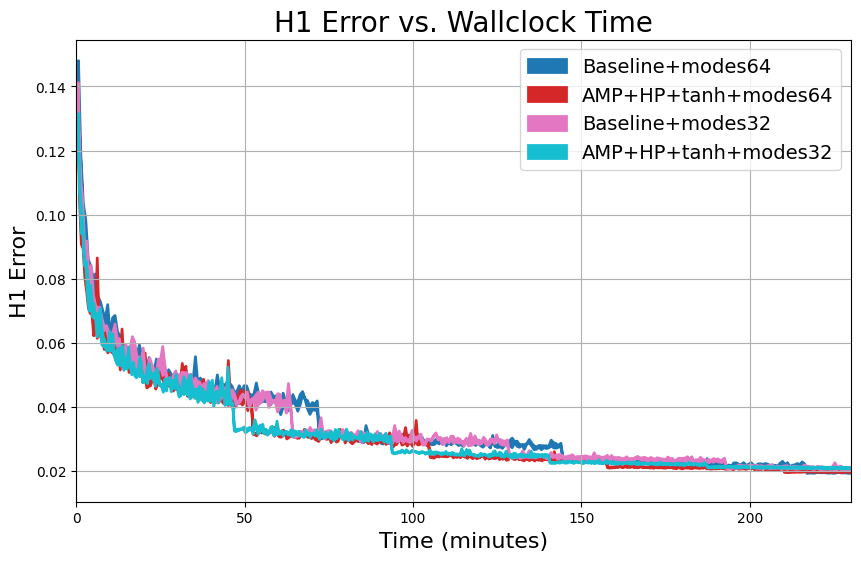

In [47]:

from scipy.spatial import ConvexHull
def plot_training_curves(data_time, data_losses, data_losses2, methods):
    plt.figure(figsize=(10, 6))

    x = np.arange(len(methods))
    colors = plt.cm.get_cmap('tab10', len(methods))
    line_styles = ['-', '-', '-', '-']
    markers = ['o', 's', '^', 'x']
    line_widths = [2]*4
    #alphas = [0.8, 1.0, 0.8, 0.7]

    for i, method in enumerate(methods):        
        time = data_time[method]
        losses = data_losses[method]

        losses_seed2 = data_losses2[method]
        max_errors = np.maximum(losses, losses_seed2)
        min_errors = np.minimum(losses, losses_seed2)
        
        cumulative_time = np.nancumsum(time) / 60  # Calculate cumulative time
        #plt.plot(cumulative_time, losses, label=method,  color=colors[i], linestyle=line_styles[i], linewidth=line_widths[i], alpha=alphas[i])
        plt.fill_between(cumulative_time, min_errors, max_errors, label=method,  color=colors(i), linestyle=line_styles[i], linewidth=line_widths[i])


    
    plt.xlabel('Time (minutes)', fontsize=16)
    plt.xlim([0, 230])
    plt.ylabel('H1 Error', fontsize=16)
    plt.title('H1 Error vs. Wallclock Time', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.savefig('error_vs_time.pdf', format='pdf')
    plt.show()


methods = ids.keys()

plot_training_curves(data_time, data_128_h1, data_128_h1_seed2, methods)


/home/renbo/anaconda3/envs/low-precision/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


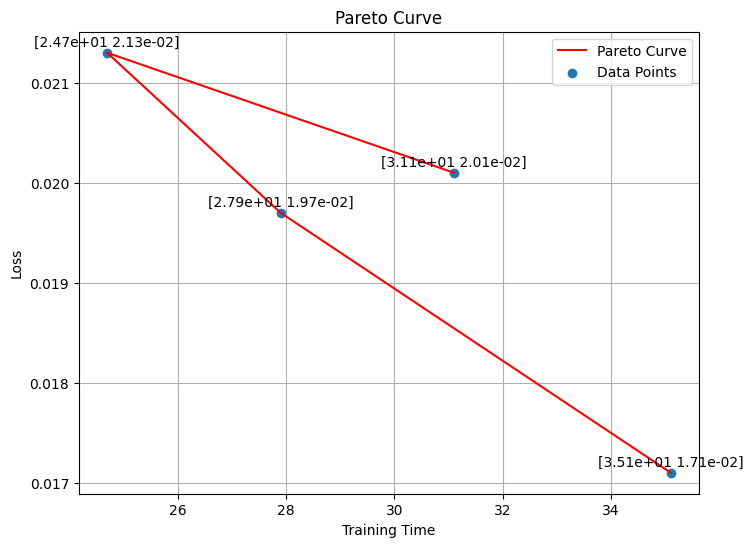

In [40]:


def plot_pareto_curve(training_time, loss):
    plt.figure(figsize=(8, 6))

    # Plot data points
    plt.scatter(training_time, loss, label='Data Points')

    # Combine training_time and loss into a single array
    points = np.column_stack((training_time, loss))

    # Calculate convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    # Sort Pareto curve points based on training time
    pareto_training_time = hull_points[:, 0]
    pareto_loss = hull_points[:, 1]

    # Plot Pareto curve
    plt.plot(pareto_training_time, pareto_loss, color='red', label='Pareto Curve')

    # Add annotations to each point
    for i, txt in enumerate(hull_points):
        plt.annotate(txt, (pareto_training_time[i], pareto_loss[i]), textcoords="offset points", xytext=(0,5), ha='center')

    plt.xlabel('Training Time')
    plt.ylabel('Loss')
    plt.title('Pareto Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
training_time = [31.1, 24.7, 35.1, 27.9]
loss = [0.0201, 0.0213, 0.0171, 0.0197]

plot_pareto_curve(training_time, loss)

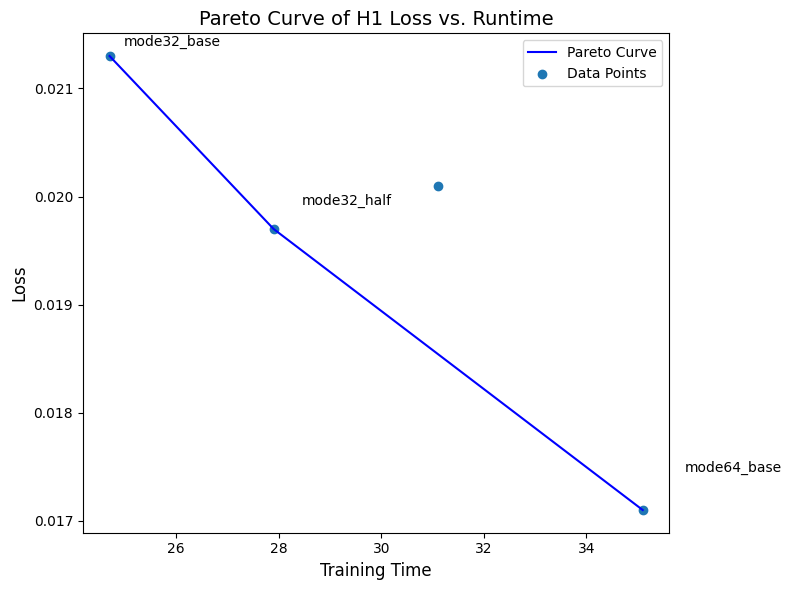

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pareto_curve(training_time, loss):
    plt.figure(figsize=(8, 6))
    plt.scatter(training_time, loss, label='Data Points')

    # Find the leftmost, bottom-most, and additional point
    leftmost_idx = np.argmin(training_time)
    bottommost_idx = np.argmin(loss)
    #additional_idx = np.where((training_time < training_time[leftmost_idx]) & (loss < loss[bottommost_idx]))[0]
    additional_idx = 3

    # Plot the leftmost, bottom-most, and additional points
    #plt.scatter(training_time[leftmost_idx], loss[leftmost_idx], color='red')
    #plt.scatter(training_time[bottommost_idx], loss[bottommost_idx], color='green')
    #plt.scatter(training_time[additional_idx], loss[additional_idx], color='orange')

    # Connect the points in the Pareto curve
    pareto_points = np.array([[training_time[leftmost_idx], loss[leftmost_idx]],
                              [training_time[bottommost_idx], loss[bottommost_idx]],
                              [training_time[additional_idx], loss[additional_idx]]])
    pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]
    plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='blue', label='Pareto Curve')

    # Add method names as annotations
    text_offset = 10
    for i, (x, y) in enumerate(pareto_points):
        method_name = methods[i]
        plt.annotate(f'{method_name}', (x, y), textcoords="offset points",
                     xytext=(text_offset, text_offset), ha='left', va='center')
        text_offset += 10

    plt.xlabel('Training Time', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Pareto Curve of H1 Loss vs. Runtime', fontsize=14)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Example usage:
training_time = [31.1, 24.7, 35.1, 27.9]
loss = [0.0201, 0.0213, 0.0171, 0.0197]
methods = ['mode32_base', 'mode32_half', 'mode64_base', 'mode64_half']

plot_pareto_curve(training_time, loss)

In [53]:


def plot_pareto_curve(training_time, loss, methods):
    plt.figure(figsize=(8, 6))

    # Plot the data points
    plt.scatter(training_time, loss)
    # Find the leftmost, bottom-most, and additional point
    leftmost_idx = np.argmin(training_time)
    bottommost_idx = np.argmin(loss)
    #additional_idx = np.where((training_time < training_time[leftmost_idx]) & (loss < loss[bottommost_idx]))[0]
    additional_idx = 5
    additional_idx_1 = 6
    additional_idx_2 = 7

    # Plot the leftmost, bottom-most, and additional points
    #plt.scatter(training_time[leftmost_idx], loss[leftmost_idx], color='red')
    #plt.scatter(training_time[bottommost_idx], loss[bottommost_idx], color='green')
    #plt.scatter(training_time[additional_idx], loss[additional_idx], color='orange')

    # Connect the points in the Pareto curve
    pareto_points = np.array([[training_time[leftmost_idx], loss[leftmost_idx]],
                              [training_time[bottommost_idx], loss[bottommost_idx]],
                              [training_time[additional_idx], loss[additional_idx]],
                              [training_time[additional_idx_1], loss[additional_idx_1]],
                              [training_time[additional_idx_2], loss[additional_idx_2]]])
    pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]
    plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='black', label='Pareto Curve')

    # Create a dictionary to map each unique method to a color and a legend handle
    method_legend_handles = {}
    
    # Plot the data points with the same color and legend handle for the same method
    for i, method in enumerate(methods):
        if method not in method_legend_handles:
            color = plt.cm.tab10(len(method_legend_handles))
            legend_handle = plt.scatter([], [], color=color, label=method)
            method_legend_handles[method] = legend_handle
        plt.scatter(training_time[i], loss[i], color=method_legend_handles[method].get_facecolor()[0])
    
    
    plt.xlabel('Training Time', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Pareto Curve of H1 Loss vs. Runtime', fontsize=20)
    # Create a shared legend for data points with the same method
    legend_handles = [method_legend_handles[method] for method in method_legend_handles]
    plt.legend(handles=legend_handles, fontsize=14, loc='upper right')
    
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('pareto_curve_v100.pdf', format='pdf')
    plt.show()


# Example usage:
training_time = [31.1, 24.7, 35.1, 27.9]
loss = [0.0201, 0.0213, 0.0171, 0.0197]
training_time.extend([30.8, 24.6, 35.3, 27.7])
loss.extend([0.0201, 0.0213, 0.0171, 0.0197])

methods = ['Baseline_mode32', 'AMP+Half+Tanh_mode32', 'Baseline_mode64', 'AMP+Half+Tanh_mode64']
methods.extend(['Baseline_mode32', 'AMP+Half+Tanh_mode32', 'Baseline_mode64', 'AMP+Half+Tanh_mode64'])

#plot_pareto_curve(training_time, loss, methods)


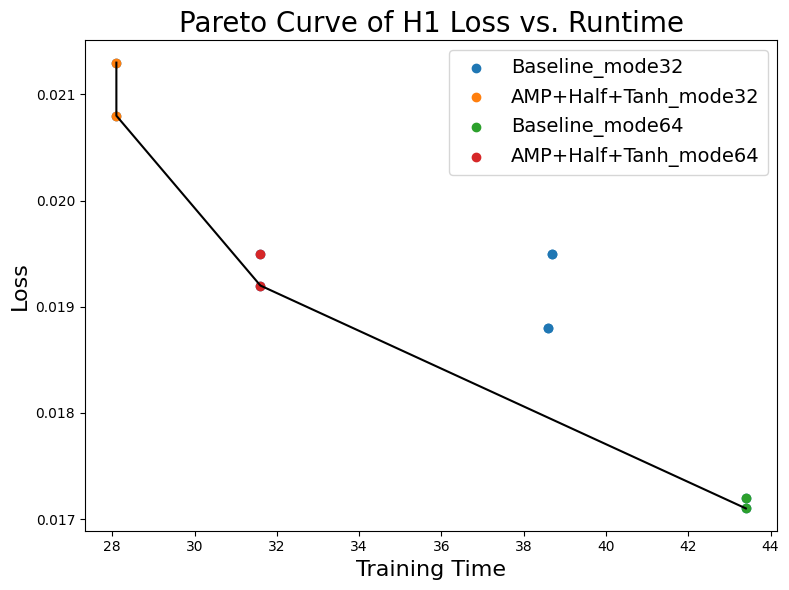

In [54]:

training_time = [38.7, 28.1, 43.4, 31.6, 38.6, 28.1, 43.4, 31.6]
loss = [0.0195, 0.0213, 0.0172, 0.0195, 0.0188, 0.0208, 0.0171, 0.0192 ]
methods = ['Baseline_mode32', 'AMP+Half+Tanh_mode32', 'Baseline_mode64', 'AMP+Half+Tanh_mode64']
methods.extend(methods)

plot_pareto_curve(training_time, loss, methods)

In [48]:
def plot_runtimes(runtimes, labels):
    plt.figure(figsize=(10, 6))

    x = np.arange(len(runtimes))
    colors = plt.cm.get_cmap('Set3', len(runtimes))

    # Find the index of the slowest method
    slowest_idx = np.argmax(runtimes)
    slowest_time = runtimes[slowest_idx]

    # Calculate speedup percentage for each method
    speedups = [(slowest_time - t) / slowest_time * 100 for t in runtimes]

    # Sort runtimes and labels based on slowest to fastest
    runtimes_sorted, labels_sorted, speedups_sorted = zip(*sorted(zip(runtimes, labels, speedups), reverse=True))

    bars = plt.bar(x, runtimes_sorted, color=colors(x))
    plt.xticks(x, labels_sorted, rotation='horizontal', fontsize=16)
    plt.xlabel('Methods', fontsize=18)
    plt.ylabel('Runtime (seconds)', fontsize=18)
    plt.title('Runtimes of Methods per Epoch', fontsize=20)
    plt.grid(False)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{speedups_sorted[i]:.1f}%', ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    plt.savefig('runtimes_v100.pdf', format='pdf')

    plt.show()

# Example usage:
runtimes = [44.44,
42.25,
39.02,
35.63,]
#37.35]
labels = ['Baseline',
'AMP',
'Half-Precision FNO (Half)',
'AMP + Half',]
#'AMP + HP + full-FFT']


#plot_runtimes(runtimes, labels)

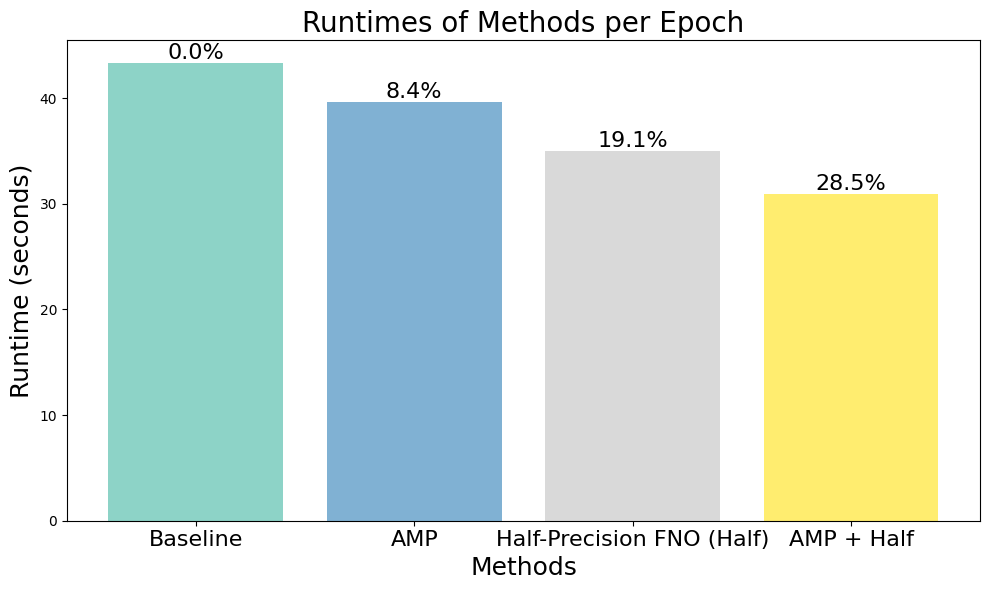

In [50]:
# Example usage:
runtimes = [43.3,
39.65,
35.01,
30.96,]
#37.8]

labels = ['Baseline',
'AMP',
'Half-Precision FNO (Half)',
'AMP + Half',]
#'AMP + HP + full-FFT']

plot_runtimes(runtimes, labels)

/tmp/ipykernel_2149009/3439310078.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3', len(methods))


<Figure size 1200x800 with 0 Axes>

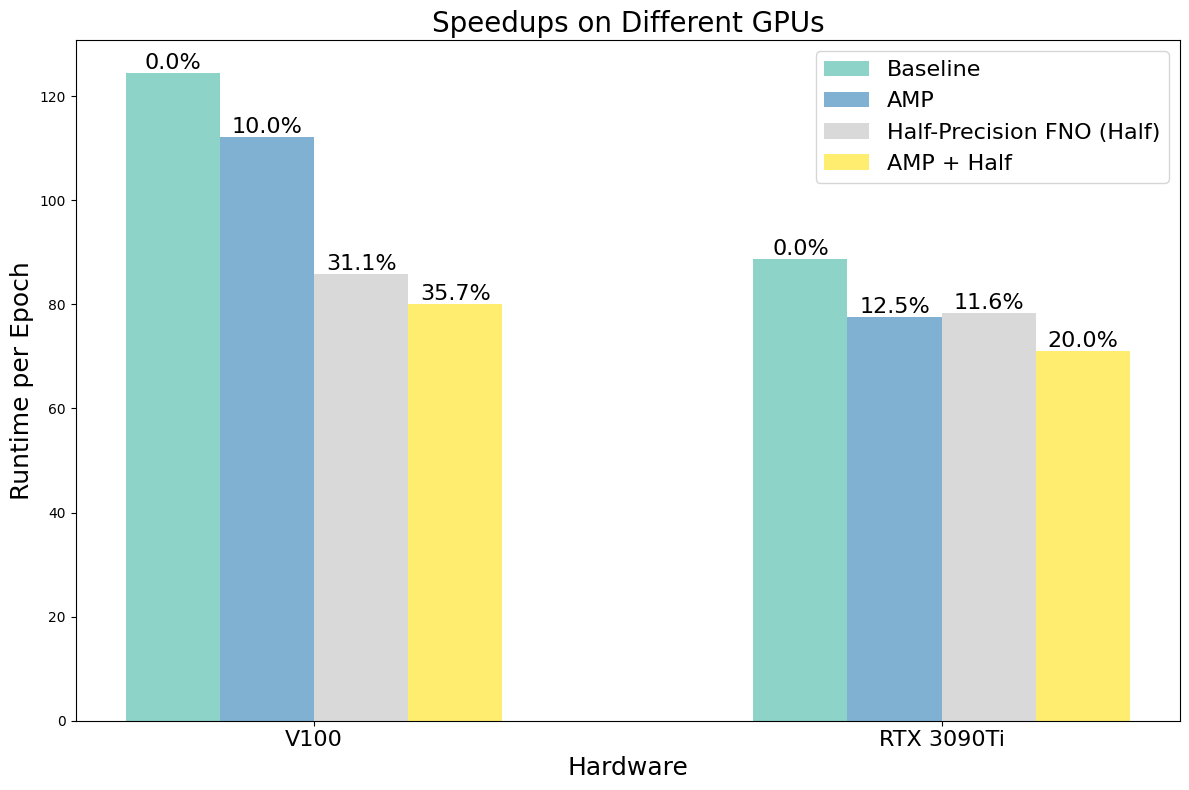

In [37]:
def plot_runtimes_hardware(runtimes_full, runtime_amp, runtimes_half, runtime_all, labels):
    plt.figure(figsize=(12, 8))

    plt.figure(figsize=(12, 8))

    methods = labels
    num_methods = len(methods)
    num_hardware = 2
    
    bar_width = 0.15
    colors = plt.cm.get_cmap('Set3', len(methods))
    hardware_labels = ['V100', 'RTX 3090Ti']
    index = np.arange(num_hardware)


    # Plot each method's bars with distinct color
    for i, runtimes in enumerate([runtimes_full, runtime_amp, runtimes_half, runtime_all]):
        bars = plt.bar(index + i * bar_width, runtimes, bar_width, label=methods[i], color=colors(i))
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{(runtimes_full[i]-height)/runtimes_full[i]*100:.1f}%', ha='center', va='bottom', fontsize=16)

    # Adjust x-ticks and labels
    plt.xticks(index + bar_width * (num_methods - 1) / 2, hardware_labels, rotation='horizontal', fontsize=16)
    
    plt.xlabel('Hardware', fontsize=18)
    plt.ylabel('Runtime per Epoch', fontsize=18)
    plt.title('Speedups on Different GPUs', fontsize=20)
    plt.grid(False)
    plt.legend(fontsize=16)

    plt.tight_layout()
    plt.savefig('runtimes_gpu_comparison.pdf', format='pdf')

    plt.show()

volta_runtimes = [124.5, 112.1, 85.8, 80.1]
ampere_runtimes = [88.7, 77.6, 78.4, 71]
runtime_pairs = list(zip(volta_runtimes, ampere_runtimes))
runtime_lists = [list(pair) for pair in runtime_pairs]

plot_runtimes_hardware(runtime_lists[0], runtime_lists[1], runtime_lists[2], runtime_lists[3], ['Baseline', 'AMP', 'Half-Precision FNO (Half)', 'AMP + Half'])

In [ ]:
def plot_memory(memory, labels):
    plt.figure(figsize=(10, 6))

    x = np.arange(len(memory))
    colors = plt.cm.get_cmap('Set3', len(memory))

    # Find the index of the slowest method
    largest_idx = np.argmax(memory)
    largest_memory = memory[largest_idx]

    # Calculate memory savings percentage for each method
    savings = [(largest_memory - m) / largest_memory * 100 for m in memory]

    # Sort memory and labels based on largest to smallest
    memory_sorted, labels_sorted, savings_sorted = zip(*sorted(zip(memory, labels, savings), reverse=True))

    bars = plt.bar(x, memory_sorted, color=colors(x))
    plt.xticks(x, labels_sorted, rotation='horizontal', fontsize=16)
    plt.xlabel('Methods', fontsize=18)
    plt.ylabel('GPU Memory Usage (GB)', fontsize=18)
    plt.title('GPU Memory Usage during Training', fontsize=20)
    plt.grid(False)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{savings_sorted[i]:.1f}%', ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    plt.savefig('memory_3090.pdf', format='pdf')

    plt.show()

In [ ]:
runtimes = [43.3,
39.65,
35.01,
30.96,]
#37.8]

labels = ['Baseline',
'AMP',
'Half-Precision FNO (Half)',
'AMP + Half',]
#'AMP + HP + full-FFT']

plot_runtimes(runtimes, labels)

/tmp/ipykernel_2216319/985133971.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3', n_methods)


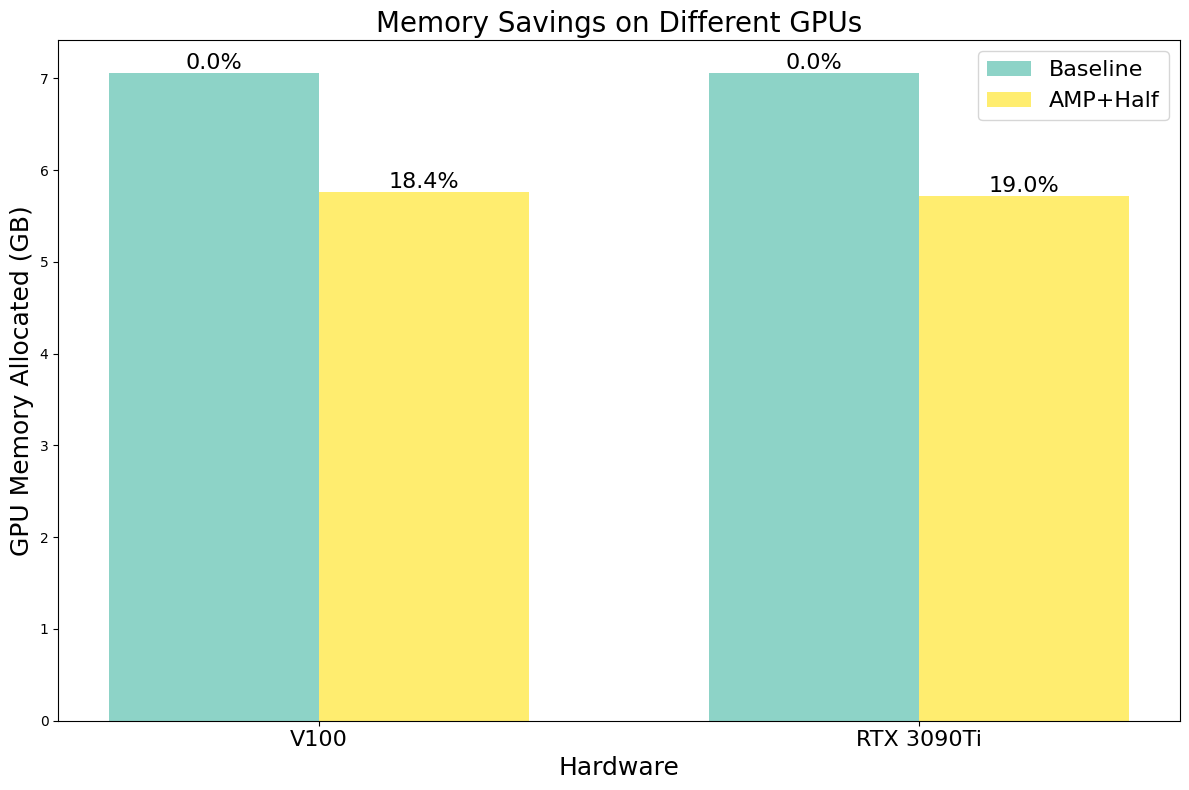

In [8]:
def plot_memory_hardware(memory_full, memory_half, labels):
    plt.figure(figsize=(12, 8))

    n_methods = len(labels)
    bar_width = 0.35
    index = np.arange(n_methods)
    colors = plt.cm.get_cmap('Set3', n_methods)

    bars_full = plt.bar(index, memory_full, bar_width, color=colors(0), label=labels[0])
    bars_half = plt.bar(index + bar_width, memory_half, bar_width, color=colors(1), label=labels[1])

    plt.xticks(index + bar_width / 2, ['V100', 'RTX 3090Ti'], rotation='horizontal', fontsize=16)
    plt.xlabel('Hardware', fontsize=18)
    plt.ylabel('GPU Memory Allocated (GB)', fontsize=18)
    plt.title('Memory Savings on Different GPUs', fontsize=20)
    plt.grid(False)
    plt.legend(fontsize=16)

    for bars in [bars_full, bars_half]:
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{(memory_full[i]- height)/memory_full[i]*100:.1f}%', ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    plt.savefig('memory_comparison.pdf', format='pdf')

    plt.show()

plot_memory_hardware([7.06, 7.06], [5.76, 5.72], ['Baseline', 'AMP+Half'])